In [1]:
# Imports:
import numpy as np
import pandas as pd
import math
import seaborn as sns
import matplotlib.pyplot as plt
import pickle
import sklearn
from sklearn.metrics import mean_squared_error
import plotly.express as px
from scipy import stats
from scipy.stats import norm
from dieboldmariano import dm_test

import torch
import pickle
import random

In [2]:
#set seed for reproducibility
random_state = 42
np.random.seed(random_state)

In [3]:
Year = 2020

In [4]:
bidirectional_results_path = '/Users/mvilenko/Library/CloudStorage/OneDrive-PayPal/CPI_HRNN - version 2.0/mayas_project/reversed_hgru_with_corr_1 - Canada/test_predictions_with_hgru.pickle'
hgru_results_path = '/Users/mvilenko/Library/CloudStorage/OneDrive-PayPal/CPI_HRNN - version 2.0/mayas_project/hgru_model_canada/test_predictions.pickle'
baseline_results_path = '/Users/mvilenko/Library/CloudStorage/OneDrive-PayPal/CPI_HRNN - version 2.0/mayas_project/basic_model_canada/data/predictions_dict.pickle'

actual_path = '/Users/mvilenko/Library/CloudStorage/OneDrive-PayPal/CPI_HRNN - version 2.0/pickle files/bi_directional_canada_dataset_dict.pickle'

In [5]:
with open(bidirectional_results_path, 'rb') as f:
    bidirectional_preds = pickle.load(f)

with open(hgru_results_path, 'rb') as f:
    hgru_preds = pickle.load(f)

with open(baseline_results_path, 'rb') as f:
    baseline_preds = pickle.load(f)

with open(actual_path, 'rb') as f:
    raw_dataset_dict = pickle.load(f)

In [6]:
bidirectional_preds['All-items'].shape

torch.Size([1, 25])

In [7]:
hgru_preds['All-items'].shape

torch.Size([1, 25])

In [8]:
baseline_preds['All-items'].shape

torch.Size([1, 25])

In [9]:
raw_dataset_dict['All-items']

,Category_id,Category,Year,Date,Price,Inflation t-12,Inflation t-11,Inflation t-10,Inflation t-9,Inflation t-8,...,Inflation t-4,Inflation t-3,Inflation t-2,Inflation t-1,Inflation t,Inflation t+1,Indent,Weight,Parent,Parent_ID
0,2,All-items,2013,2013-01-15,121.3,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,1.147554,0.0,1.0,NaN,NaN
1,2,All-items,2013,2013-02-15,122.7,1.147554,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,0.162866,0.0,1.0,NaN,NaN
2,2,All-items,2013,2013-03-15,122.9,0.162866,1.147554,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,-0.162866,0.0,1.0,NaN,NaN
3,2,All-items,2013,2013-04-15,122.7,-0.162866,0.162866,1.147554,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,0.244200,0.0,1.0,NaN,NaN
4,2,All-items,2013,2013-05-15,123.0,0.244200,-0.162866,0.162866,1.147554,NaN,...,NaN,NaN,NaN,NaN,NaN,0.000000,0.0,1.0,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
117,2,All-items,2022,2022-10-15,153.8,0.717784,0.065509,-0.327118,0.130719,0.656170,...,1.027055,0.898727,-0.138793,0.208261,0.697353,0.129955,0.0,1.0,NaN,NaN
118,2,All-items,2022,2022-11-15,154.0,0.129955,0.717784,0.065509,-0.327118,0.130719,...,1.420382,1.027055,0.898727,-0.138793,0.208261,-0.586130,0.0,1.0,NaN,NaN
119,2,All-items,2022,2022-12-15,153.1,-0.586130,0.129955,0.717784,0.065509,-0.327118,...,0.602613,1.420382,1.027055,0.898727,-0.138793,0.521174,0.0,1.0,NaN,NaN
120,2,All-items,2023,2023-01-15,153.9,0.521174,-0.586130,0.129955,0.717784,0.065509,...,1.392134,0.602613,1.420382,1.027055,0.898727,0.389106,0.0,1.0,NaN,NaN


In [10]:
def create_test_dataframe(raw_dataset_dict: dict):
    test_dict = {}
    for key in raw_dataset_dict.keys():
        df = raw_dataset_dict[key][['Category', 'Date', 'Year', 'Inflation t+1']]
        df.dropna(inplace=True)
        df.rename(columns={'Inflation t+1': 'Actual'}, inplace=True)
        target_df = df[df['Year'] > Year]
        test_dict[key] = target_df
    return test_dict

test_dict = create_test_dataframe(raw_dataset_dict)


/var/folders/88/mkn0vj0s1kl1179x22s6j2h80000gq/T/ipykernel_63806/483307922.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.dropna(inplace=True)
/var/folders/88/mkn0vj0s1kl1179x22s6j2h80000gq/T/ipykernel_63806/483307922.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.rename(columns={'Inflation t+1': 'Actual'}, inplace=True)
/var/folders/88/mkn0vj0s1kl1179x22s6j2h80000gq/T/ipykernel_63806/483307922.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#return

In [11]:
def get_df_with_predictions(bi_direc_preds: dict, hrnn_preds: dict, baseline_preds: dict, dict_of_categories_df:dict) -> dict:
    all_data_dict = {}
    for key in list(bi_direc_preds.keys()):
        bi_directional_predictions = bi_direc_preds[key]
        hrnn_predictions = hrnn_preds[key]
        baseline_predictions = baseline_preds[key]
        
        bi_directional_pred_df =  pd.DataFrame(bi_directional_predictions.flatten().detach().numpy())
        bi_directional_pred_df.rename(columns = {0: 'Bi-Directional Prediction'}, inplace=True)
        
        hrnn_pred_df =  pd.DataFrame(hrnn_predictions.flatten().detach().numpy())
        hrnn_pred_df.rename(columns = {0: 'HRNN Prediction'}, inplace=True)

        baseline_pred_df =  pd.DataFrame(baseline_predictions.flatten().detach().numpy())
        baseline_pred_df.rename(columns = {0: 'Baseline Prediction'}, inplace=True)

        dict_of_categories_df[key] = dict_of_categories_df[key].reset_index(drop=True)
        df1 = pd.concat([dict_of_categories_df[key], bi_directional_pred_df], axis=1)
        df2 = pd.concat([df1, hrnn_pred_df], axis=1)
        df3 = pd.concat([df2, baseline_pred_df], axis=1)

        all_data_dict[key] = df3

    return all_data_dict

all_data_test_dict=get_df_with_predictions(bidirectional_preds, hgru_preds, baseline_preds , test_dict)

-------

In [12]:
def diebold_mariano_test_better_categories(all_data_test_dict):
    better_cats_pval = []
    all_pvals = []
    for category in list(all_data_test_dict.keys()):
        df = all_data_test_dict[category]
        forecast_bi_directional = df['Bi-Directional Prediction']
        forecast_hrnn = df['HRNN Prediction']
        actual_values = df['Actual']

        squared_errors_bi_directional = (forecast_bi_directional - actual_values)**2
        squared_errors_hrnn = (forecast_hrnn - actual_values)**2

        dm_statistic = dm_test(actual_values, forecast_bi_directional, forecast_hrnn, one_sided=True)
        
        if np.mean(squared_errors_bi_directional) < np.mean(squared_errors_hrnn):
            better_cats_pval.append(dm_statistic[1])
        
        all_pvals.append(dm_statistic[1])

    print(f'Number of Better Categories: {len(better_cats_pval)}')
    print(f'Total Categories: {len(list(all_data_test_dict.keys()))}')
    print(f"Better Category %: {round(100*len(better_cats_pval)/len(list(all_data_test_dict.keys())),4)}")
    print(f'Average P-value Better Categories: {np.mean(better_cats_pval)}')
    print(f'Average P-value All Categories: {np.mean(all_pvals)}')
        
    return better_cats_pval, all_pvals

In [13]:
res = diebold_mariano_test_better_categories(all_data_test_dict)

Number of Better Categories: 271
Total Categories: 293
Better Category %: 92.4915
Average P-value Better Categories: 0.1253964043393245
Average P-value All Categories: 0.17206770590648948


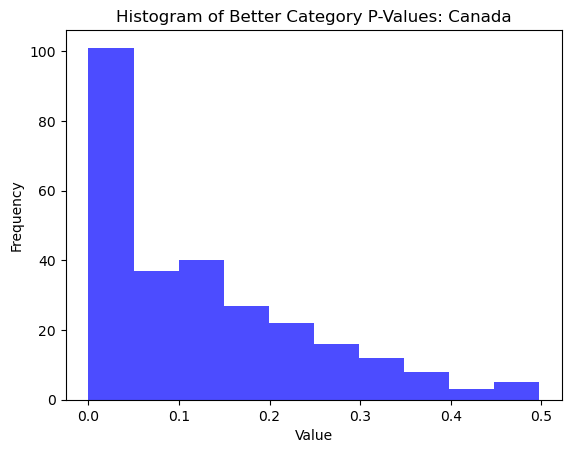

In [14]:
# Creating the histogram
plt.hist(res[0], bins='auto', color='blue', alpha=0.7)
plt.title('Histogram of Better Category P-Values: Canada')
plt.xlabel('Value')
plt.ylabel('Frequency')
plt.show()


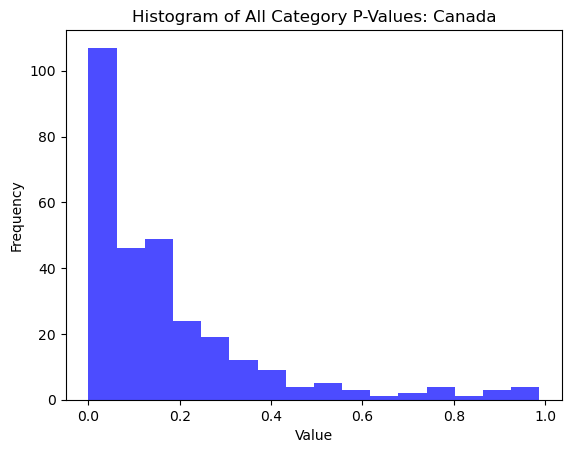

In [15]:

# Creating the histogram
plt.hist(res[1], bins='auto', color='blue', alpha=0.7)
plt.title('Histogram of All Category P-Values: Canada')
plt.xlabel('Value')
plt.ylabel('Frequency')
plt.show()


In [16]:
def diebold_mariano_test_better_categories2(all_data_test_dict):
    better_cats_pval = []
    all_pvals = []
    for category in list(all_data_test_dict.keys()):
        df = all_data_test_dict[category]
        forecast_bi_directional = df['Bi-Directional Prediction']
        forecast_hrnn = df['HRNN Prediction']
        actual_values = df['Actual']

        squared_errors_bi_directional = (forecast_bi_directional - actual_values)**2
        squared_errors_hrnn = (forecast_hrnn - actual_values)**2

        dm_statistic = dm_test(actual_values, forecast_bi_directional, forecast_hrnn, one_sided=True)
        
        if (np.mean(squared_errors_bi_directional) < np.mean(squared_errors_hrnn)) and (dm_statistic[1]<0.1):
            better_cats_pval.append(dm_statistic[1])
        
        all_pvals.append(dm_statistic[1])

    print(f'Number of Better Categories: {len(better_cats_pval)}')
    print(f'Total Categories: {len(list(all_data_test_dict.keys()))}')
    print(f"Better Category %: {round(100*len(better_cats_pval)/len(list(all_data_test_dict.keys())),4)}")
    print(f'Average P-value Better Categories: {np.mean(better_cats_pval)}')
    print(f'Average P-value All Categories: {np.mean(all_pvals)}')
        
    return better_cats_pval, all_pvals

In [17]:
res2 = diebold_mariano_test_better_categories2(all_data_test_dict)

Number of Better Categories: 138
Total Categories: 293
Better Category %: 47.099
Average P-value Better Categories: 0.032993855959103105
Average P-value All Categories: 0.17206770590648948


In [18]:
def diebold_mariano_test_better_categories2(all_data_test_dict):
    better_cats_pval = []
    all_pvals = []
    for category in list(all_data_test_dict.keys()):
        df = all_data_test_dict[category]
        forecast_bi_directional = df['Bi-Directional Prediction']
        forecast_hrnn = df['HRNN Prediction']
        actual_values = df['Actual']

        squared_errors_bi_directional = (forecast_bi_directional - actual_values)**2
        squared_errors_hrnn = (forecast_hrnn - actual_values)**2

        dm_statistic = dm_test(actual_values, forecast_bi_directional, forecast_hrnn, one_sided=True)
        
        if (np.mean(squared_errors_bi_directional) < np.mean(squared_errors_hrnn)) and (dm_statistic[1]<0.05):
            better_cats_pval.append(dm_statistic[1])
        
        all_pvals.append(dm_statistic[1])

    print(f'Number of Better Categories: {len(better_cats_pval)}')
    print(f'Total Categories: {len(list(all_data_test_dict.keys()))}')
    print(f"Better Category %: {round(100*len(better_cats_pval)/len(list(all_data_test_dict.keys())),4)}")
    print(f'Average P-value Better Categories: {np.mean(better_cats_pval)}')
    print(f'Average P-value All Categories: {np.mean(all_pvals)}')
        
    return better_cats_pval, all_pvals

In [19]:
res2 = diebold_mariano_test_better_categories2(all_data_test_dict)

Number of Better Categories: 101
Total Categories: 293
Better Category %: 34.471
Average P-value Better Categories: 0.017400614047471064
Average P-value All Categories: 0.17206770590648948


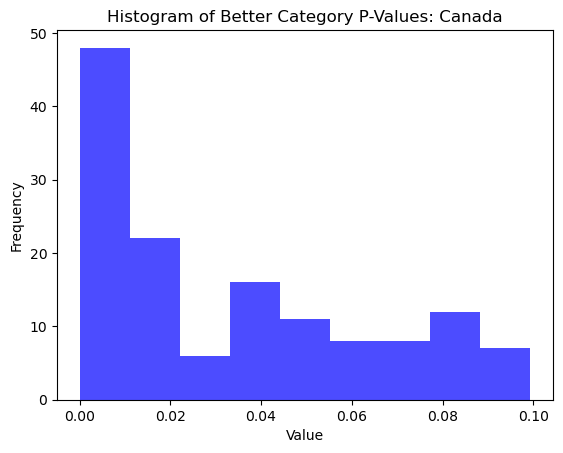

In [27]:
# Creating the histogram
plt.hist(res2[0], bins='auto', color='blue', alpha=0.7)
plt.title('Histogram of Better Category P-Values: Canada')
plt.xlabel('Value')
plt.ylabel('Frequency')
plt.show()


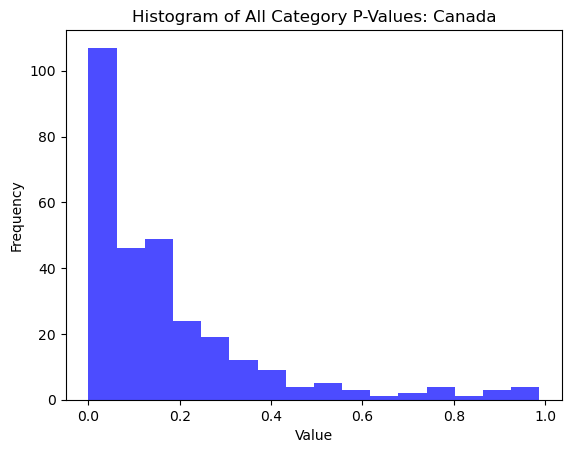

In [28]:

# Creating the histogram
plt.hist(res2[1], bins='auto', color='blue', alpha=0.7)
plt.title('Histogram of All Category P-Values: Canada')
plt.xlabel('Value')
plt.ylabel('Frequency')
plt.show()


----

In [20]:
def diebold_mariano_test(forecast_model1, forecast_model2, actual_values):
    # Calculate squared forecast errors for both models
    squared_errors_model1 = (forecast_model1 - actual_values)**2
    squared_errors_model2 = (forecast_model2 - actual_values)**2
    
    # Calculate Mean Squared Forecast Errors (MSFE) for both models
    msfe_model1 = np.mean(squared_errors_model1)
    msfe_model2 = np.mean(squared_errors_model2)
    
    # Calculate the difference in MSFE
    diff_msfe = msfe_model1 - msfe_model2
    
    # Calculate the variance of the difference
    var_diff = np.var(squared_errors_model1 - squared_errors_model2) / len(actual_values)
    
    # Calculate the Diebold-Mariano test statistic
    dm_statistic = diff_msfe / np.sqrt(var_diff)
    
    # Calculate the p-value
    p_value = 2 * (1 - norm.cdf(np.abs(dm_statistic)))  # Two-tailed test
    
    return dm_statistic, p_value

In [21]:
def diebold_mariano_test_all_categories(all_data_test_dict):
    list_of_squared_errors_bi_directional = []
    list_of_squared_errors_hrnn = []
    for category in list(all_data_test_dict.keys()):
        df = all_data_test_dict[category]
        forecast_bi_directional = df['Bi-Directional Prediction']
        forecast_hrnn = df['HRNN Prediction']
        actual_values = df['Actual']

        # Calculate squared forecast errors for both models
        squared_errors_bi_directional = (forecast_bi_directional - actual_values)**2
        squared_errors_hrnn = (forecast_hrnn - actual_values)**2

        list_of_squared_errors_bi_directional.append(squared_errors_bi_directional)
        list_of_squared_errors_hrnn.append(squared_errors_hrnn)

    list_of_squared_errors_bi_directional = pd.concat(list_of_squared_errors_bi_directional)
    list_of_squared_errors_hrnn = pd.concat(list_of_squared_errors_hrnn)

    #print(f'num categories: {len(list(all_data_test_dict.keys()))}')
    #print(f'list of sqrd errors bi directional: {len(list_of_squared_errors_bi_directional)}')
    #print(f'list of sqrd errors: {len(list_of_squared_errors_hrnn)}')


    # Calculate Mean Squared Forecast Errors (MSFE) for both models
    msfe_bi_directional = np.mean(list_of_squared_errors_bi_directional)
    msfe_hrnn = np.mean(list_of_squared_errors_hrnn)
    
    # Calculate the difference in MSFE
    diff_msfe = msfe_bi_directional - msfe_hrnn

    # Calculate the variance of the difference
    var_diff = np.var(list_of_squared_errors_bi_directional - list_of_squared_errors_hrnn) / len(list_of_squared_errors_bi_directional)
    
    # Calculate the Diebold-Mariano test statistic
    dm_statistic = diff_msfe / np.sqrt(var_diff)
    
    # Calculate the p-value
    p_value = 2 * (1 - norm.cdf(np.abs(dm_statistic)))  # Two-tailed test
        
    return dm_statistic, p_value

In [22]:
dm_statistic, p_value = diebold_mariano_test_all_categories(all_data_test_dict)

alpha = 0.05  # Significance level (adjust as needed)

print("Diebold-Mariano Test Statistic:", dm_statistic)
print("p-value:", p_value)

if p_value < alpha:
    print("Conclusion: There is a statistically significant difference in predictive accuracy between the two models.")
else:
    print("Conclusion: There is no statistically significant difference in predictive accuracy between the two models.")


Diebold-Mariano Test Statistic: -10.47368676611787
p-value: 0.0
Conclusion: There is a statistically significant difference in predictive accuracy between the two models.


-------

In [23]:
df = all_data_test_dict['All-items']
forecast_bi_directional = df['Bi-Directional Prediction']
forecast_hrnn = df['HRNN Prediction']
actual_values = df['Actual']

In [24]:
dm_test(actual_values, forecast_bi_directional, forecast_hrnn, one_sided=False)

(-0.451088284918266, 0.6559753563970485)

In [25]:
diebold_mariano_test(forecast_bi_directional, forecast_hrnn, actual_values)

(-0.4603900529153959, 0.6452362732145742)

In [26]:
from dm_test import dm_test as dm_test2
actual_lst = df['Actual'].apply(lambda x: float(x)).tolist()
bidirect_pred_lst = df['Bi-Directional Prediction'].apply(lambda x: float(x)).tolist()
hrnn_pred_lst = df['HRNN Prediction'].apply(lambda x: float(x)).tolist()

rt = dm_test2(actual_lst,bidirect_pred_lst,hrnn_pred_lst,h = 1, crit="MAD")
print(rt)
rt = dm_test2(actual_lst,bidirect_pred_lst,hrnn_pred_lst,h = 1, crit="MSE")
print(rt)
rt = dm_test2(actual_lst,bidirect_pred_lst,hrnn_pred_lst,h = 1, crit="poly", power=4)
print(rt)


dm_return(DM=-0.9772227172952025, p_value=0.33820707673211436)
dm_return(DM=-0.45108828491826597, p_value=0.655975356397144)
dm_return(DM=-0.27542278212085486, p_value=0.7853488743652423)
